# Employee Retention

## Goal
Employee turn-over is a very costly problem for companies. The cost of replacing an employee if often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months.  

It is only natural then that data science has started being applied to this area. Understanding why and when employees are most likely to leave can lead to actions to improve employee retention as well as planning new hiring in advance. This application of DS is sometimes called people analytics or people data science (if you see a job title: people data scientist, this is your job).


In this challenge, you have a data set with info about the employees and have to predict when employees are going to quit by understanding the main drivers of employee churn.

## Chanllenge Description

We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience.  

As said above, the goal is to predict employee retention and understand its main drivers. Specifically, you should:
* Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id.  

* What are the main factors that drive employee churn? Do they make sense? Explain your findings.  

* If you could add to this data set just one variable that could help explain employee churn, what would that be?  

## Data

### Columns:
* employee_id : id of the employee. Unique by employee per company company_id : company id.
* dept : employee dept
* seniority : number of yrs of work experience when hired
* salary: avg yearly salary of the employee during her tenure within the company join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13
* quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)

## Analysis

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image  
#from sklearn.externals.six import StringIO  
from six import StringIO
from sklearn.tree import export_graphviz
import pydot 

import  warnings
warnings.simplefilter('ignore')

In [12]:
data = pd.read_csv('Employee_Rentation.csv',parse_dates=['join_date','quit_date'])
data=data.iloc[:,1:]
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  24702 non-null  float64       
 1   company_id   24702 non-null  int64         
 2   dept         24702 non-null  object        
 3   seniority    24702 non-null  int64         
 4   salary       24702 non-null  float64       
 5   join_date    24702 non-null  datetime64[ns]
 6   quit_date    13510 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.3+ MB


In [36]:
data.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


## Q1 create a table with 3 columns: day, employee_headcount, company_id.

In [37]:
date_range = pd.date_range(start='2011-01-24',end='2015-12-13',freq='D')
unique_company = sorted(data['company_id'].unique())

result=[]
for date in date_range:
    for company in unique_company:
        record = []
        head_count = len(data[(data['join_date'] <= date) & (data['company_id'] == company)])-len(data[(data['quit_date'] <= date) & (data['company_id'] == company)])
        record.append(str(date)[:10])
        record.append(company)
        record.append(head_count)
        result.append(record)
table= pd.DataFrame(result,columns=['Date','Company','Headcount'])
table.head(24)

,Date,Company,Headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5
5,2011-01-24,6,3
6,2011-01-24,7,1
7,2011-01-24,8,6
8,2011-01-24,9,3
9,2011-01-24,10,0


## Q2 What are the main factors that drive employee churn? 

In [40]:
quit_employee = data[-data['quit_date'].isnull()]
stay_employee = data[data['quit_date'].isnull()]

In [47]:
quit_employee['work_length_day']=(quit_employee['quit_date']-quit_employee['join_date']).dt.days
quit_employee

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,work_length_day
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578
...,...,...,...,...,...,...,...,...
24695,63273.0,1,data_science,5,172000.0,2012-05-01,2015-06-26,1151
24696,94644.0,6,marketing,7,88000.0,2012-01-26,2013-02-01,372
24699,777612.0,4,customer_service,11,67000.0,2013-09-03,2015-10-23,780
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09,1123


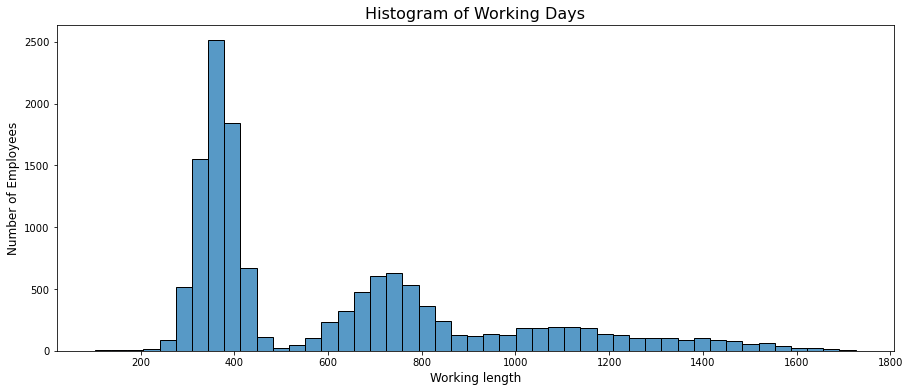

In [51]:
fig, ax=plt.subplots(figsize=(15,6))
sns.histplot(data=quit_employee['work_length_day'])
ax.set_title('Histogram of Working Days',fontsize=16)
ax.set_xlabel('Working length',fontsize=12)
ax.set_ylabel('Number of Employees',fontsize=12)
plt.show()

In [76]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month
quit_employee['work_length_month']=quit_employee.apply(lambda x: diff_month(x['quit_date'],x['join_date']),axis=1)

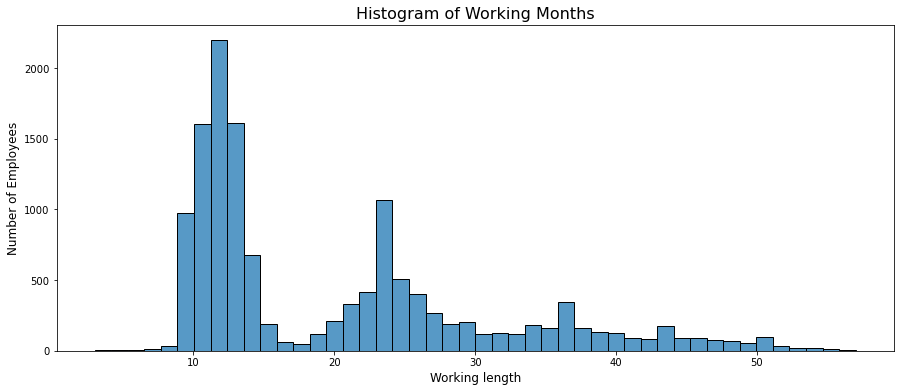

In [77]:
fig, ax=plt.subplots(figsize=(15,6))
sns.histplot(data=quit_employee['work_length_month'])
ax.set_title('Histogram of Working Months',fontsize=16)
ax.set_xlabel('Working length',fontsize=12)
ax.set_ylabel('Number of Employees',fontsize=12)
plt.show()

From the graphs above we can find an interesting observation that there are peaks around each employee year anniversary. Employees tend to leave companies after 12, 24, and 36 months.

In [90]:
quit_employee['quit_month']=quit_employee['quit_date'].dt.month
quit_employee['quit_week']=quit_employee['quit_date'].dt.week

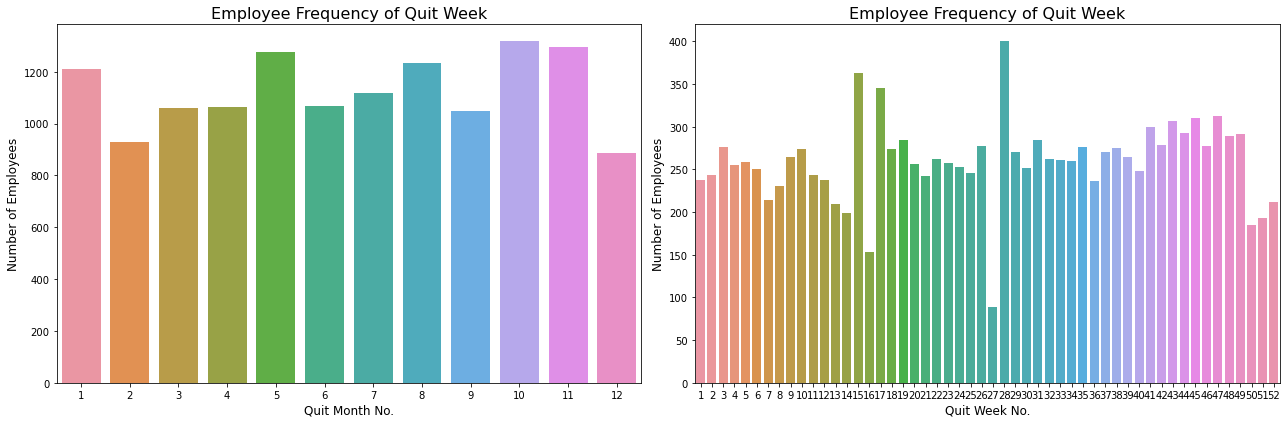

In [93]:
fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.countplot(quit_employee['quit_month'],ax=ax[0])
ax[0].set_title('Employee Frequency of Quit Week',fontsize=16)
ax[0].set_xlabel('Quit Month No.',fontsize=12)
ax[0].set_ylabel('Number of Employees',fontsize=12)
sns.countplot(quit_employee['quit_week'],ax=ax[1])
ax[1].set_title('Employee Frequency of Quit Week',fontsize=16)
ax[1].set_xlabel('Quit Week No.',fontsize=12)
ax[1].set_ylabel('Number of Employees',fontsize=12)
plt.tight_layout()
plt.show()

## Decision Tree

In [104]:
data['label']=data['quit_date'].apply(lambda x: 0 if x is pd.NaT else 1)
data2=data.copy()
data2['quit_date']=data2['quit_date'].fillna('2015-12-13')

In [106]:
data2['working_length']=(data2['quit_date']-data2['join_date']).dt.days

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,label,working_length
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,585
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,340
2,927315.0,4,marketing,14,101000.0,2014-10-13,2015-12-13,0,426
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,389
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,1040


In [133]:
train_X=data2.loc[:,['dept','seniority','salary','company_id']]
train_y=data2['label']
train_X=pd.get_dummies(train_X)

In [134]:
from sklearn.tree import DecisionTreeClassifier

In [135]:
dtree=DecisionTreeClassifier(max_depth=4,min_samples_leaf=30,random_state=101)
dtree.fit(train_X,train_y)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=30, random_state=101)

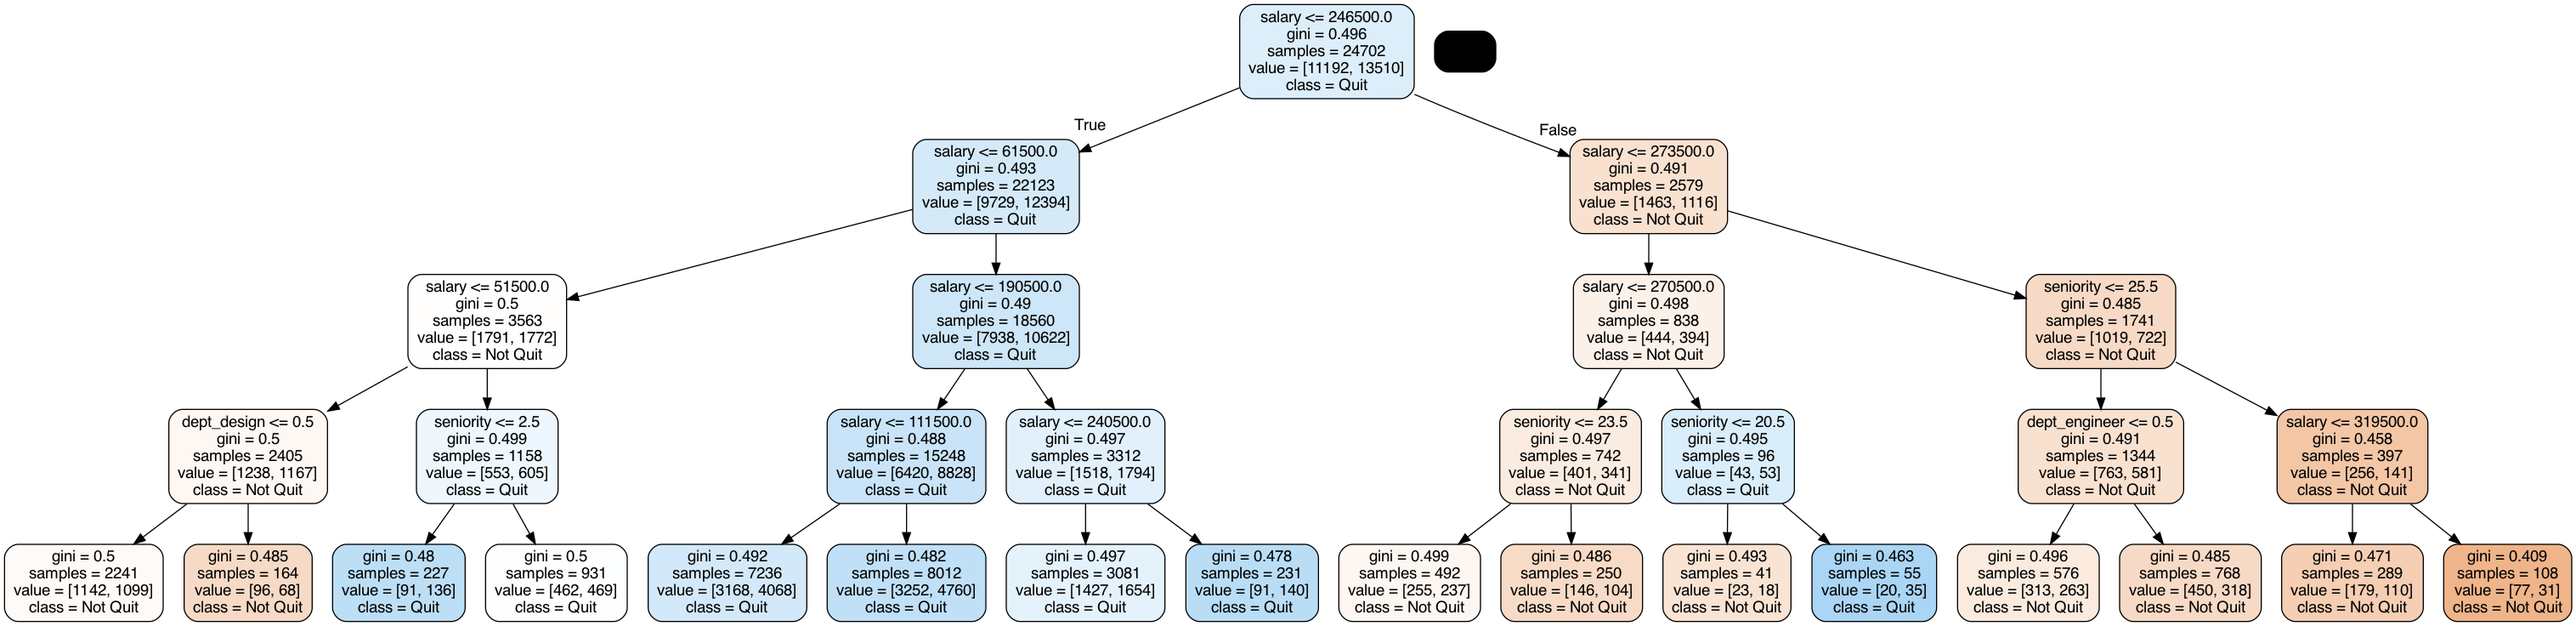

In [136]:
dot_data = StringIO()  
export_graphviz(dtree, out_file=dot_data,feature_names=train_X.columns,filled=True,rounded=True,class_names=['Not Quit','Quit'])

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())  

In [148]:
importance = sorted(zip(train_X.columns,dtree.feature_importances_),key=lambda x:x[1],reverse=True)
importance_pd = pd.DataFrame(importance,columns=['Features','Importance'])

In [152]:
importance_pd

,Features,Importance
0,salary,0.910838
1,seniority,0.069222
2,dept_design,0.011878
3,dept_engineer,0.008062
4,company_id,0.000000
5,dept_customer_service,0.000000
6,dept_data_science,0.000000
7,dept_marketing,0.000000
8,dept_sales,0.000000


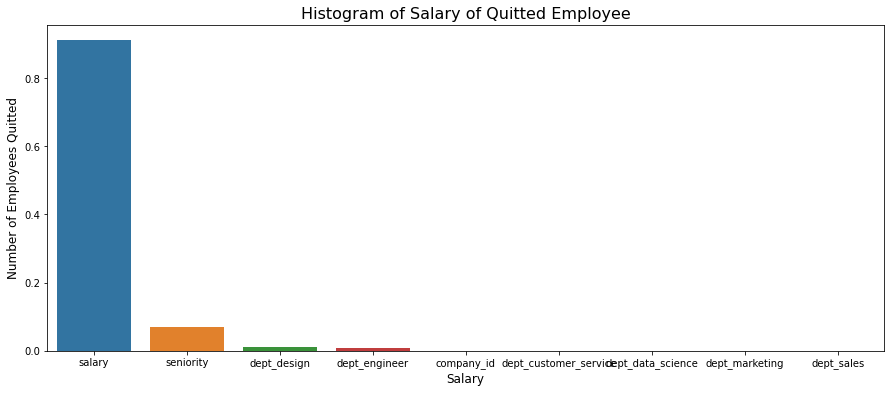

In [214]:
fig, ax=plt.subplots(figsize=(15,6))
sns.barplot(x='Features',y='Importance',data=importance_pd)
ax.set_title('Histogram of Salary of Quitted Employee',fontsize=16)
ax.set_xlabel('Salary',fontsize=12)
ax.set_ylabel('Number of Employees Quitted',fontsize=12)
plt.show()

From the treemap and importance bar chart, we can tell that salary is the most significant feature. Not very surprising! Salary is what matters the most. After all, it probably has within it infomration about the other variables too. That is, seniority, dept and company impact salary. Salary carries pretty much all the information.

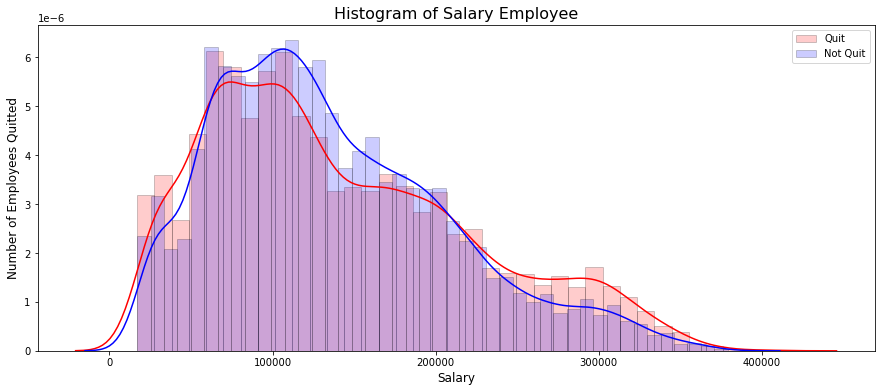

In [212]:
fig, ax=plt.subplots(figsize=(15,6))
sns.distplot(data2[data2['label']==0]['salary'],label='Quit',color='red',hist_kws={'alpha':0.2,'edgecolor':'black'})
sns.distplot(data2[data2['label']==1]['salary'],label='Not Quit',color='blue',hist_kws={'alpha':0.2,'edgecolor':'black'})
ax.set_title('Histogram of Salary Employee',fontsize=16)
ax.set_xlabel('Salary',fontsize=12)
ax.set_ylabel('Number of Employees Quitted',fontsize=12)
ax.legend()
plt.show()

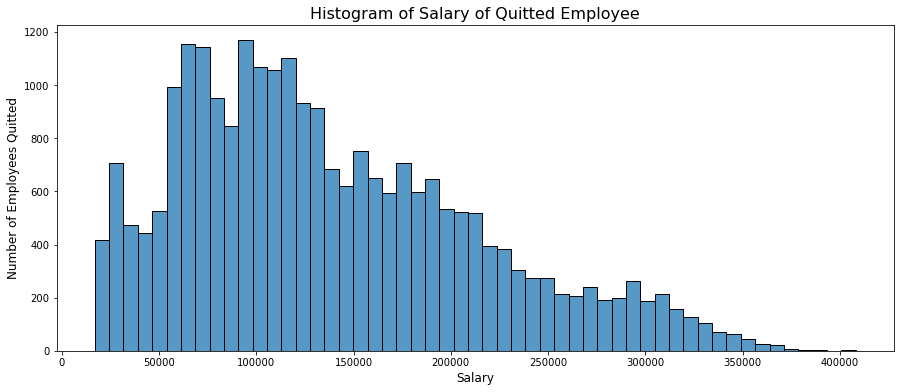

In [200]:
fig, ax=plt.subplots(figsize=(15,6))
sns.histplot(data=data2['salary'])
ax.set_title('Histogram of Salary of Quitted Employee',fontsize=16)
ax.set_xlabel('Salary',fontsize=12)
ax.set_ylabel('Number of Employees Quitted',fontsize=12)
plt.show()

In [193]:
data2['salary_percentile']=pd.qcut(data2['salary'],50,labels=np.linspace(1,50))
salary_tb=data2[['salary_percentile','employee_id','label']].groupby('salary_percentile').agg({'employee_id':'count','label':'sum'})
salary_tb.rename(columns={'employee_id':'Number of Employees','label':'Number of Employees left'},inplace=True)
salary_tb['ratio']=round(salary_tb['Number of Employees left']/salary_tb['Number of Employees'],2)
salary_tb.head(10)

,Number of Employees,Number of Employees left,ratio
salary_percentile,,,
1.0,531,260,0.49
2.0,500,243,0.49
3.0,462,214,0.46
4.0,506,248,0.49
5.0,473,240,0.51
6.0,536,287,0.54
7.0,555,280,0.50
8.0,496,281,0.57
9.0,518,292,0.56


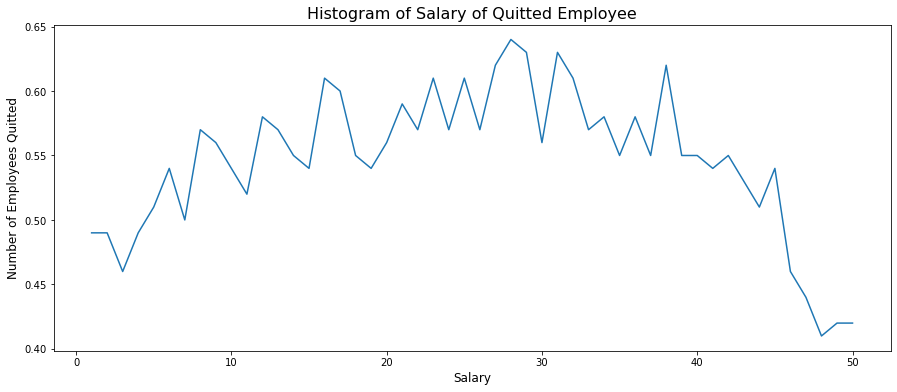

In [191]:
fig, ax=plt.subplots(figsize=(15,6))
sns.lineplot(x='salary_percentile',y='ratio',data=salary_tb)
ax.set_title('Histogram of Salary of Quitted Employee',fontsize=16)
ax.set_xlabel('Salary',fontsize=12)
ax.set_ylabel('Number of Employees Quitted',fontsize=12)
plt.show()

## Conclusions

### If you could add to this data set just one variable that could help explain employee churn, what would that be?

Given the importance of salary, I'd love to have the employees' salary of the next job. Otherwise, promotions or salary raises received during the employee tenure may also be reasons why employees left companies.

The major findings are that employees quit at their working anniversaries. That makes sense. Even if you don’t like your current job, you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait.

Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy to stay and employees with low salaries are not that marketable, so they have a hard time finding a new job.